# Boilerplate

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.precision', 2)
pd.set_option('display.float_format',  '{:,.2f}'.format)

In [2]:
# kpi_raw = pd.read_csv('../data/CSU_KPI_raw_2022-01-01_2025-01-15.csv')
kpi_raw = pd.read_csv('../data/CSU_KPI_raw_2022-01-01_2025-02-07.csv')

tiktok_raw = pd.read_csv('../data/CSU_data_tiktok_raw_2024-01-15.csv')
meta_raw = pd.read_csv('../data/CSU_data_meta_raw_2024-01-15.csv')
google_raw = pd.read_csv('../data/CSU_data_google_raw_2024-01-15.csv')
bing_raw = pd.read_csv('../data/CSU_data_bing_raw_2024-01-15.csv')
ttd_raw = pd.read_csv('../data/CSU_data_TTD_raw_2024-01-15.csv')
linkedin_raw = pd.read_csv('../data/CSU_data_linkedin_raw_2024-01-15.csv')

rev_map_raw = pd.read_excel('../data/Average revenue per application per week.xlsx')

# Process KPIs

## wrangle KPIs

In [3]:
# list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']
list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']

df_kpi_full = kpi_raw.copy()
df_kpi_full['leaddate'] = pd.to_datetime(df_kpi_full['leaddate']).dt.normalize()
df_kpi_full['appdate'] = pd.to_datetime(df_kpi_full['appdate']).dt.normalize()
df_kpi_full['enrolldate'] = pd.to_datetime(df_kpi_full['enrolldate']).dt.normalize()

df_kpi_full['model'] = None
df_kpi_full.loc[df_kpi_full['dmaname'].str.match('|'.join(list_awareness), na=False), 'model'] = 'awareness'
df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('MOBILE-PENSACOLA', na=False), 'model'] = 'mobile'
df_kpi_full.loc[df_kpi_full['model'].isna(), 'model'] = 'national'
df_kpi_full = df_kpi_full.loc[df_kpi_full['leaddate'] < pd.Timestamp.today()].drop(['dmaname'], axis=1) 

df_kpi_full['channel'] = None
df_kpi_full.loc[df_kpi_full['dw_channel'].str.contains('PPL'), 'channel'] = 'PPL'
df_kpi_full.loc[df_kpi_full['channel'].isna(), 'channel'] = 'ALL(No PPL,Referral)' #NO PPL BUT Everything else
df_kpi_full = df_kpi_full.loc[df_kpi_full.leaddate < '2025-01-10'] ##keeping with saturday-friday

df_kpi_cohort = df_kpi_full.loc[df_kpi_full.model != 'mobile'].copy()
df_kpi_cohort = df_kpi_cohort.loc[df_kpi_full.channel != 'PPL'].copy()

df_kpi_cohort = df_kpi_cohort[['leaddate','n_lead','n_app','model']].reset_index(drop=True)

df_kpi_cohort = df_kpi_cohort.groupby(['leaddate','model']).agg(n_app=('n_app','sum'), n_lead=('n_lead','sum'))
df_kpi_daily = df_kpi_cohort.unstack('model').fillna(0)
df_kpi_weekly = df_kpi_daily.resample('W-Mon', closed='left', label='left').sum()
df_kpi_weekly.index.name='date'
# df_kpi_weekly = df_kpi_weekly.droplevel(0, axis=1)
# df_kpi_weekly = df_kpi_weekly.reset_index(drop=False)
# df_kpi_weekly = df_kpi_weekly.rename(columns={'leaddate':'date'})

model_name, model_kpi = 'awareness', 'n_lead'

dict_models = {}
dict_models[model_name] = df_kpi_weekly[(model_kpi, model_name)].copy()
dict_models[model_name] = pd.DataFrame(dict_models[model_name]) 
dict_models[model_name].columns = [model_kpi]
dict_models[model_name] = dict_models[model_name].reset_index(drop=False)

# dict_models['awareness'] = dict_models['awareness'].rename(columns={'awareness':'n_app'})
# dict_models['awareness'].columns.name=None

model_name, model_kpi = 'national', 'n_app'

dict_models[model_name] = df_kpi_weekly[(model_kpi, model_name)].copy()
dict_models[model_name] = pd.DataFrame(dict_models[model_name]) 
dict_models[model_name].columns = [model_kpi]
dict_models[model_name] = dict_models[model_name].reset_index(drop=False)

## Investigate lead to app 

In [4]:
# Investigtion done earlier. Finding is we need max 2-4 weeks to cohorts to mature. 1 Is probably fine (see previous notebook).
# As a consequence going to train 2023-2024 full year for this first pass and then just stay 1 month behind leading data.

In [5]:
df_perc = df_kpi_full.loc[df_kpi_full.model=='awareness', ['n_lead','n_app']].sum()
lead2app_awareness = df_perc['n_app']/df_perc['n_lead']

In [6]:
lead2app_awareness

0.22142372881355932

## Get revenue

In [7]:
# def create_shifted_array(arr, shifts, n_pad=None):
def create_shifted_array(arr_in, n_size):
    """
    Creates an array containing shifted versions of the input array.

    Args:
        arr (numpy.ndarray): The input array.
        shifts (list of int): A list of integers representing the shift amounts.
        n_pad (int): how

    Returns:
        numpy.ndarray: An array where each row is a shifted version of the input array.
    """
    arr_in = arr_in.reshape(-1)
    arr = np.zeros(n_size)
    arr[:len(arr_in)] = arr_in
    arr_out = np.zeros((n_size, n_size))
    shifts = np.arange(n_size)
    for shift in shifts:
        tmp = np.roll(arr, shift)
        tmp[:shift] = 0
        arr_out[:, shift] = tmp
        #     rows.append(tmp)
    return arr_out

def calc_conv(k, v):
    k = np.array(k)
    v_out = np.array(v)
    v_out = v_out.reshape(-1)
    k_mat = create_shifted_array(k, len(v))
    conv = np.sum(k_mat*v_out, -1)
    return conv

In [8]:
rev_map_app = rev_map_raw[[2023]].copy()
rev_map_app = rev_map_app[~rev_map_app[2023].isna()]
rev_map_lead = rev_map_app.mul(lead2app_awareness)

kernel_app = rev_map_app.values.flatten() #len = 52
kernel_lead = rev_map_lead.values.flatten() #len = 52

x_val_a = np.array(dict_models['awareness']['n_lead'].values) #len = 159
x_val_n = np.array(dict_models['national']['n_app'].values) #len = 159

rev_n = np.round(calc_conv(kernel_app, x_val_n), 2)
rev_a = np.round(calc_conv(kernel_lead, x_val_a), 2)

df_rev_n = pd.DataFrame({'date': dict_models['national']['date'], 'revenue': rev_n})
df_rev_a = pd.DataFrame({'date': dict_models['awareness']['date'], 'revenue': rev_a})

## Check KPI with rev graphs

In [9]:
df_a = dict_models['awareness'].merge(df_rev_a, how='left', on='date')
df_n = dict_models['national'].merge(df_rev_n, how='left', on='date')

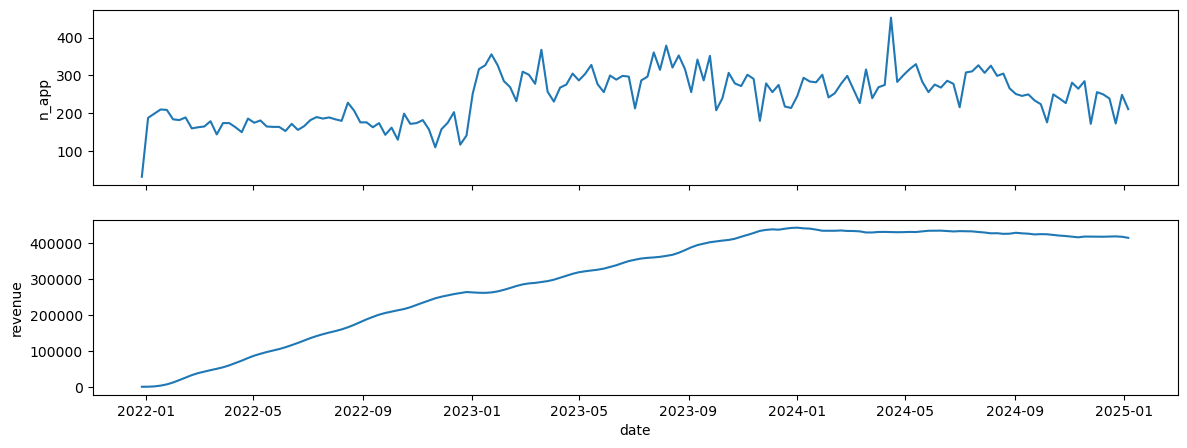

In [10]:
df_g = df_n.copy()

fig, axes = plt.subplots(2,1, figsize=(14,5), sharex=True)

sns.lineplot(data=df_g, x='date', y='n_app', ax=axes[0])
sns.lineplot(data=df_g, x='date', y='revenue', ax=axes[1]);

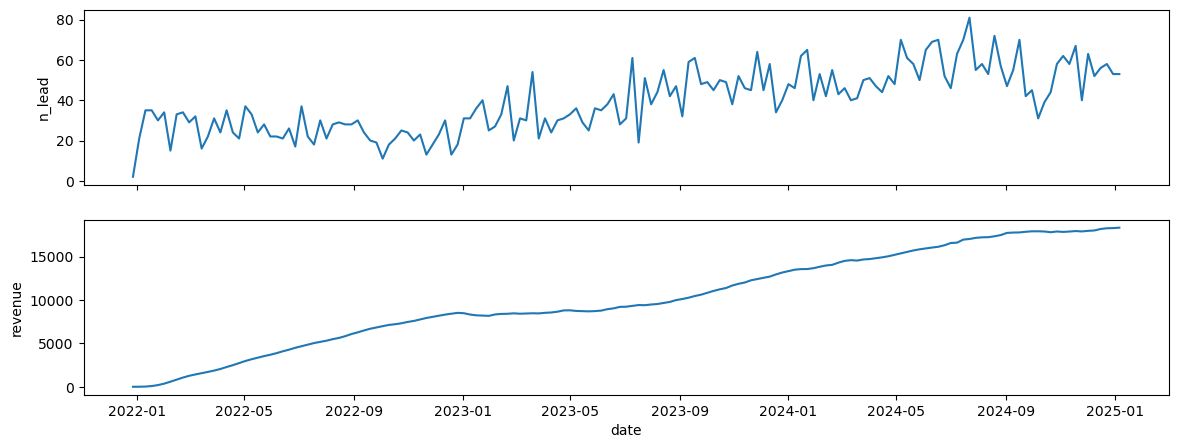

In [11]:
df_g = df_a.copy()

fig, axes = plt.subplots(2,1, figsize=(14,5), sharex=True)

sns.lineplot(data=df_g, x='date', y='n_lead', ax=axes[0])
sns.lineplot(data=df_g, x='date', y='revenue', ax=axes[1]);

# Wrangle media

In [12]:
# list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'GREENWOOD-GREENVILLE, MS', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM, AL']
list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM, AL']

df_goo = google_raw.copy()
df_goo['Date'] = pd.to_datetime(df_goo['Date'])
df_goo['Metro area'] = df_goo['Metro area'].str.upper()
df_goo['dma'] = None
df_goo.loc[df_goo['Metro area'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_goo.loc[df_goo['Metro area'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_goo.loc[df_goo['dma'].isna(), 'dma'] = 'national'
df_goo = df_goo.loc[df_goo.dma != 'mobile']
df_goo['channel'] = None
df_goo.loc[df_goo['Brand'] == 'Brand', 'channel'] = 'Brand'
df_goo.loc[df_goo['Campaign name'].str.contains('YouTube'), 'channel'] = 'YouTube'
df_goo.loc[df_goo['Campaign name'].str.contains('Display'), 'channel'] = 'Display'
df_goo.loc[df_goo['Campaign name'].str.contains('Discovery'), 'channel'] = 'Display'
df_goo.loc[df_goo['Campaign name'].str.contains('DemandGen'), 'channel'] = 'Display'
df_goo.loc[df_goo['channel'].isna(), 'channel'] = 'Non-Brand' ###not certain if this is what we can make nonBrand
df_goo = df_goo.rename(columns={'Cost':'spend', 'Date':'date'})
df_goo = df_goo[['date', 'dma', 'channel', 'spend']]

In [13]:
# list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'GREENWOOD-GREENVILLE, MS', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM']
list_awareness = ['GREENVILLE-SPARTANBURG, SC-ASHEVILLE, NC-ANDERSON, SC', 'JACKSONVILLE, FL', 'ORLANDO-DAYTONA BEACH-MELBOURNE, FL', 'BIRMINGHAM (ANNISTON AND TUSCALOOSA), AL']

df_bing = bing_raw.copy()
df_bing['Date'] = pd.to_datetime(df_bing['Date'])
df_bing['Visitor metro area'] = df_bing['Visitor metro area'].str.upper()
df_bing['dma'] = None
df_bing.loc[df_bing['Visitor metro area'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_bing.loc[df_bing['Visitor metro area'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_bing = df_bing.loc[df_bing.dma != 'mobile']
df_bing.loc[df_bing['dma'].isna(), 'dma'] = 'national'
df_bing['channel'] = None
df_bing.loc[df_bing['Brand'] == 'Brand', 'channel'] = 'Brand'
df_bing.loc[df_bing['Brand'] == 'Non Brand', 'channel'] = 'Non-Brand'
df_bing = df_bing.rename(columns={'Cost':'spend', 'Date':'date'})
df_bing = df_bing.groupby(['date', 'dma', 'channel'])['spend'].agg('sum').reset_index()

C:\Users\ktaljan\AppData\Local\Temp\ipykernel_25652\622751373.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_bing.loc[df_bing['Visitor metro area'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'


In [14]:
# list_awareness = ['GREENVILLE - SPARTANBURG - ASHEVILLE - ANDERSON', 'JACKSONVILLE', 'GREENWOOD - GREENVILLE', 'ORLANDO - DAYTONA BEACH - MELBOURNE', 'BIRMINGHAM']
list_awareness = ['GREENVILLE - SPARTANBURG - ASHEVILLE - ANDERSON', 'JACKSONVILLE', 'ORLANDO - DAYTONA BEACH - MELBOURNE', 'BIRMINGHAM']

df_tiktok = tiktok_raw.copy()
df_tiktok['Date'] = pd.to_datetime(df_tiktok['Date'])
df_tiktok['DMA name'] = df_tiktok['DMA name'].str.upper()
df_tiktok['dma'] = None
df_tiktok.loc[df_tiktok['DMA name'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_tiktok.loc[df_tiktok['DMA name'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_tiktok = df_tiktok.loc[df_tiktok.dma != 'mobile']
df_tiktok.loc[df_tiktok['dma'].isna(), 'dma'] = 'national'
df_tiktok['channel'] = 'TikTok'
df_tiktok = df_tiktok.rename(columns={'Cost':'spend', 'Date':'date'})
df_tiktok = df_tiktok[['date', 'dma', 'channel', 'spend']]

In [15]:
# list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM']
list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM']

df_meta = meta_raw.copy()
df_meta['Date'] = pd.to_datetime(df_meta['Date'])
df_meta['DMA'] = df_meta['DMA'].str.upper()
df_meta['dma'] = None
df_meta.loc[df_meta['DMA'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_meta.loc[df_meta['DMA'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_meta = df_meta.loc[df_meta.dma != 'mobile']
df_meta.loc[df_meta['dma'].isna(), 'dma'] = 'national'
df_meta['channel'] = 'Meta'
df_meta = df_meta.rename(columns={'Cost':'spend', 'Date':'date'})
df_meta = df_meta[['date', 'dma', 'channel', 'spend']]

In [16]:
# list_awareness = ['GREENVILLE-SPARTANBURG SC-ASHEVILLE NC-ANDERSON SC', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BEACH-MELBOURNE', 'BIRMINGHAM']
list_awareness = ['GREENVILLE-SPARTANBURG SC-ASHEVILLE NC-ANDERSON SC', 'JACKSONVILLE', 'ORLANDO-DAYTONA BEACH-MELBOURNE', 'BIRMINGHAM']

df_ttd = ttd_raw.copy()
df_ttd['record_date'] = pd.to_datetime(df_ttd['record_date'])
df_ttd['metro'] = df_ttd['metro'].str.upper()
df_ttd['dma'] = None
df_ttd.loc[df_ttd['metro'].str.contains('|'.join(list_awareness), na=False), 'dma'] = 'awareness'
df_ttd.loc[df_ttd['metro'].str.contains('MOBILE', na=False), 'dma'] = 'mobile'
df_ttd = df_ttd.loc[df_ttd.dma != 'mobile']
df_ttd.loc[df_ttd['dma'].isna(), 'dma'] = 'national'
df_ttd.loc[df_ttd['campaign_name'].str.contains('DOOH'), 'channel'] = 'DOOH'
df_ttd.loc[df_ttd['campaign_name'].str.contains('|'.join(['CTV', 'OTT'])), 'channel'] = 'CTV/OTT'
df_ttd.loc[df_ttd['campaign_name'].str.contains('Audio'), 'channel'] = 'Digital Radio'
df_ttd = df_ttd.rename(columns={'cost':'spend', 'record_date':'date'})
df_ttd = df_ttd[['date', 'dma', 'channel', 'spend']]

In [17]:
 ### LinkedIn has no geo splitting from platform
df_li = linkedin_raw.copy()
df_li = df_li.rename(columns={'record_date':'date', 'cost':'spend'})
df_li['date'] = pd.to_datetime(df_li['date'])
df_li = df_li.groupby('date')['spend'].agg('sum').reset_index()
df_li['channel'] = 'LinkedIn'
df_li['dma'] = 'unknown'

In [21]:
df_spend = pd.concat([df_bing, df_goo, df_meta, df_tiktok, df_ttd, df_li])
df_spend = df_spend.groupby(['date', 'dma', 'channel'])['spend'].agg('sum')
df_spend_daily = df_spend.reset_index().copy()

df_spend_weekly = df_spend.unstack(['dma', 'channel']).sort_index(axis=1).fillna(0)
df_spend_weekly = df_spend_weekly.resample('W-Mon', closed='left', label='left').sum()
df_spend_weekly_aware = df_spend_weekly['awareness']
df_spend_weekly_national = df_spend_weekly[['national', 'unknown']]
df_spend_weekly_national.columns = df_spend_weekly_national.columns.droplevel()

df_spend_weekly_aware = df_spend_weekly_aware.reset_index(drop=False)
df_spend_weekly_national = df_spend_weekly_national.reset_index(drop=False)

# # df_spend_monthly = df_spend.unstack(['dma', 'channel']).sort_index(axis=1).fillna(0)
# # df_spend_monthly = df_spend_monthly.resample('MS').sum()

df_a_out = df_a.merge(df_spend_weekly_aware, how='left', on='date')
df_a_out['LinkedIn'] = 0
df_n_out = df_n.merge(df_spend_weekly_national, how='left', on='date')

dt_1, dt_2 = '2023-01-01', '2025-01-01'
df_a_out = df_a_out[(df_a_out['date']>=dt_1)&(df_a_out['date']<dt_2)].reset_index(drop=True)
df_n_out = df_n_out[(df_n_out['date']>=dt_1)&(df_n_out['date']<dt_2)].reset_index(drop=True)

df_a_out = df_a_out.round(2)
df_n_out = df_n_out.round(2)

In [22]:
df_a_out.to_csv('../data/data-full_awareness_2025-02-10.csv', index=False)
df_n_out.to_csv('../data/data-full_national_2025-02-10.csv', index=False)

In [23]:
df_n_out

,date,n_app,revenue,Brand,CTV/OTT,DOOH,Digital Radio,Display,Meta,Non-Brand,TikTok,YouTube,LinkedIn
0,2023-01-02,252.00,"262,445.55","25,473.52",0.00,0.00,0.00,"2,102.21","9,303.81","47,104.67",0.00,"1,091.05",0.00
1,2023-01-09,317.00,"261,534.21","23,384.96",0.00,0.00,0.00,"2,735.82","12,732.64","50,591.24",0.00,"1,393.19",0.00
2,2023-01-16,327.00,"261,340.92","20,145.80",0.00,0.00,0.00,"2,803.84","12,671.73","49,745.32",0.00,"1,323.29",0.00
3,2023-01-23,356.00,"262,518.65","22,492.01",0.00,0.00,0.00,"2,936.22","12,526.74","52,580.00",0.00,"1,255.91",0.00
4,2023-01-30,327.00,"265,329.59","21,671.06",0.00,0.00,0.00,"2,523.81","7,548.69","52,423.52",0.00,"1,379.99",0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2024-12-02,256.00,"417,813.82","24,120.28",0.00,0.00,0.00,"8,487.73","22,181.41","100,049.66","4,417.98","2,171.87","3,429.99"
101,2024-12-09,250.00,"417,458.66","22,275.31",0.00,0.00,0.00,"8,420.86","22,364.74","105,259.62","4,333.91","2,222.66","3,430.00"
102,2024-12-16,239.00,"418,023.81","20,387.91",0.00,0.00,0.00,"8,272.90","22,401.13","103,647.90","4,684.75","2,126.42","3,830.00"
103,2024-12-23,173.00,"418,432.36","13,918.92",0.00,0.00,0.00,"7,709.09","23,298.98","90,416.94","5,489.14","2,046.13","4,874.85"


In [24]:
df_a_out

,date,n_lead,revenue,Brand,CTV/OTT,DOOH,Digital Radio,Display,Meta,Non-Brand,TikTok,YouTube,LinkedIn
0,2023-01-02,31.00,"8,473.91","1,215.18",0.00,0.00,0.00,80.15,367.29,"1,321.29",0.00,43.38,0
1,2023-01-09,31.00,"8,320.86","1,207.92",0.00,0.00,0.00,105.95,527.15,"1,461.58",0.00,50.22,0
2,2023-01-16,36.00,"8,232.71","1,193.86",0.00,0.00,0.00,116.53,572.51,"2,189.59",0.00,53.71,0
3,2023-01-23,40.00,"8,201.65","1,037.24",0.00,0.00,0.00,85.50,608.94,"2,150.82",0.00,55.26,0
4,2023-01-30,25.00,"8,169.48",913.15,0.00,0.00,0.00,112.84,333.51,"2,426.11",0.00,50.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2024-12-02,63.00,"17,963.63","1,380.16","15,366.56",0.00,"4,668.10",586.65,"1,133.65","4,900.52",145.25,"6,386.15",0
101,2024-12-09,52.00,"18,005.83","1,302.11","15,223.47",0.00,"4,692.72",552.16,"1,130.63","5,967.92",169.34,"6,373.00",0
102,2024-12-16,56.00,"18,176.38","1,128.57","15,178.02",0.00,"4,717.17",495.48,"1,167.69","4,867.90",179.05,"6,459.19",0
103,2024-12-23,58.00,"18,261.09","1,032.21","14,472.52",0.00,"4,667.92",469.12,"1,262.81","3,790.85",218.76,"6,233.35",0


# Checking some numbers - scrap

In [39]:
df_ = df_kpi_daily.resample('MS').sum()
df_month = pd.DataFrame(index=df_.index)
df_month['lead'] = df_.loc[:, ('n_lead', slice(None))].sum(axis=1)
df_month['app'] = df_.loc[:, ('n_app', slice(None))].sum(axis=1)

In [42]:
df_month[-12:-1]

,lead,app
leaddate,,
2024-02-01,"4,858.00","1,155.00"
2024-03-01,"4,984.00","1,200.00"
2024-04-01,"5,724.00","1,440.00"
2024-05-01,"7,442.00","1,386.00"
2024-06-01,"6,625.00","1,214.00"
2024-07-01,"7,297.00","1,388.00"
2024-08-01,"7,494.00","1,373.00"
2024-09-01,"6,793.00","1,074.00"
2024-10-01,"6,495.00","1,056.00"
